## Part 3: Predictive Modeling

The following is a summary of the process used to build a model to predict passenger retention. All code used is below.

### Data Cleaning


**Missing values** 

Missing values were found in the following columns:
* avg_rating_of_driver 
* phone
* avg_rating_by_driver

The median was used to impute missing values for avg_rating_of_driver and avg_rating_by_driver. This was because the mean appeared to be impacted by a small number of very low ratings. An 'Unknown' category was created to represent the missing phone values. 

**Data Types**

After analyzing the data types of the raw data, signup_date and last_trip_date were converted to the **datetime** data type.

**Outliers**

The following **outliers** were identified in the data:
* There was a user that took 125 trips in the first 30 days  
* There was an average surge of 8
* There was a surge percentage of 100  

However, all the outliers were deemed plausible and were not removed.

### Exploratory Data Analysis

**User Retention**

Note that the "current" date that should be used to calculate the preceding 30 days was not provided. Therefore, the most recent date in the last_trip_date column was assumed to be the "current" date. This was used to calculate user retention.

The overall user retention was roughly **37.6%**

**Potential Predictors and Observations:**

* King's Landing had much higher passenger retention than the other two cities.
* Retention rate tended to increase as users took more trips in the first 30 days. 
* Retention rate tended to increase for users who rated the drivers more highly. However the rate leveled off above ratings of 3.
* Retention rates tended to be lower for passengers with either a very low or very high average surge.
* Retention tended to be higher for iPhones.
* Retention rate tended to be lower for passengers with either a very low or very high surge percentage. Note that surge percentage and average surge had very similar trends.
* Retention appeared higher among Ultimate Black subscribers.
* Retention was greater for passengers whose weekday percentage was 10-90%. Retention was lower for passengers with more extreme weekday percentages.
* Retention tended to be lower when average distance was below roughly 1.5 miles or above roughly 13 miles. Retention was greatest when average distance was roughly between 2 and 6 miles.
* Retention tended to increase steadily as the passenger rating increased - especially when the rating was above 3.

**Correlation:**

* avg_surge and surge_pct were highly correlated. 

**Dropped Features:**

* Since the target feature was derived from last_trip_date, last_trip_date should not be used in modeling and was dropped.
* Since all users were from the same signup cohort, the signup_date was not used for modeling (it may have been a useful feature if signup dates were over a wider timeframe, allowing seasonality to be analyzed).

**Feature Engineering:**

* Since avg_surge and surge_pct were highly correlated, they were combined (multiplied) into a single feature and the original features were dropped. The new feature was called surge_product.
* The total distance traveled in the first 30 days may have had some relevance. This was calculated from average distance and number of trips in the first 30 days. The new feature was called total_distance_first_30_days.

### Preprocessing

* boolean columns were converted to integer columns (0 = False and 1 = True)
* data was split into X (feature matrix) and y (target vector)
* data was split into train and test sets (70/30 split)
* categorical columns were encoded using One-Hot encoding.
* numerical columns were scaled using standard scaling.

### Modeling

The approach to modeling was build several initial models. Logistic Regression, Gradient Boosting, and Random Forest models were tested. A dummy model was used to establish baseline performance. The Gradient Boosting model was selected for several reasons. First, it had the best initial score in terms of both ROC-AUC and Accuracy. Also, it appeared to generalize very well to the test data, as the train and test scores were almost identical. Therefore, the model appeared to have high validity. 

After selecting the Gradient Boosting model, hyperparameter tuning was used to see if model performance could be improved. Both Accuracy and ROC-AUC improved slightly. The final model had an accuracy of 0.79 and a ROC-AUC of 0.86.

However, one concern is that we cannot be sure how well the model will generalize to other passenger cohorts. Data was only available for a single passenger cohort. It is possible that there was bias in this passenger cohort. 

### Conclusions / Insights

The following features showed the greatest importance in predicting passenger retention:
* average rating by driver
* passenger resides in King's Landing
* surge_product
* weekday_pct

It may be possible to target passengers whose average rating by driver indicates that they will not be retained. Marketing efforts (such as offering discounts) could be used in an effort to retain those passengers. King's Landing tends to have higher retention. This should be analyzed to determine whether retention in the other cities can improved. It may be that there are more drivers per capita in King's Landing and Ultimate could attempt to increase the number of drivers in the other cities. On the other hand, it may be due to factors outside of Ultimate's control. For example, there may be a lower vehicle ownership rate in King's Landing. Because surge appeared to be important, Ultimate may want to take a customer's retention likelihood into account and adjust surge charges accordingly. Weekday percentage was also a predictor. Ultimate may want to consider offering weekday discounts to passengers with low weekday ridership. 

## Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn import model_selection, preprocessing, ensemble, metrics, linear_model, dummy

## Gather Data

In [2]:
#read the data into pandas
file_path = 'ultimate_data_challenge.json'
df_users = pd.read_json(file_path)

## 1. Data Wrangling

In [3]:
#first few rows of data
df_users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


## 1.1 Data Types and Missing Values

In [4]:
#look at datatypes, look for missing values
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
#convert signup_date and last_trip_date to datetime
df_users['signup_date'] = pd.to_datetime(df_users.signup_date)
df_users['last_trip_date'] = pd.to_datetime(df_users.last_trip_date)

In [6]:
#inspect the values in the phone column
df_users.phone.value_counts(dropna=False)

iPhone     34582
Android    15022
NaN          396
Name: phone, dtype: int64

In [7]:
#there may be something unique about users with a missing phone value that helps to predict user retention.
# therefore, NaN values will be replaced with "Unknown" in order to capture this group of users.

df_users['phone'] = df_users.phone.fillna('Unknown')

In [8]:
#summary statistics for numerical columns
df_users.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [9]:
#for avg_rating_of_driver, avg_rating_by_driver impute missing values using the median. Median was selected because,
# looking at the summary statistics above, the mean was influenced by a small number of low ratings.

#imputation for avg_rating_of_driver
df_users['avg_rating_of_driver'] = df_users.avg_rating_of_driver.fillna(df_users.avg_rating_of_driver.median())

#imputation for avg_rating_by_driver
df_users['avg_rating_by_driver'] = df_users.avg_rating_by_driver.fillna(df_users.avg_rating_by_driver.median())

In [10]:
#re-inspect the dataframe summary after updating datatypes and imputing missing values
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

## 1.2. Outlier Values

In [11]:
df_users.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.650038,1.074764,8.849536,60.926084,5.796827,4.779050
std,3.792684,0.575601,0.222336,19.958811,37.081503,5.707357,0.445974
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


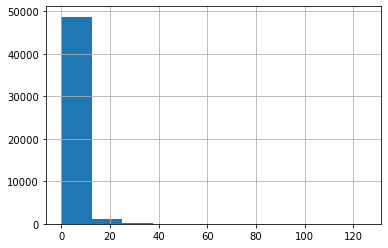

In [12]:
#The maximum trips_in_first_30_days value appears extreme. 

#Inspect the distribution for the trips_in_first_30_days column
df_users.trips_in_first_30_days.hist();

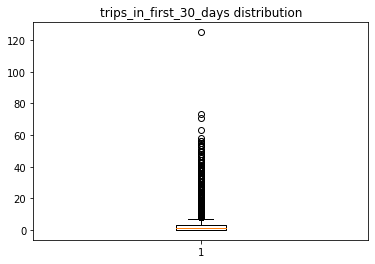

In [13]:
#boxplot of the trips_in_first_30_days data
fig, ax = plt.subplots()
ax.boxplot(df_users.trips_in_first_30_days);
ax.set_title('trips_in_first_30_days distribution');

In [14]:
#users that took 50 or more trips in the first 30 days
mask = df_users.trips_in_first_30_days >= 50
df_users[mask].sort_values(by='trips_in_first_30_days', ascending=False)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8
99,Astapor,73,2014-01-27,4.9,1.00,2014-03-05,Android,0.0,True,89.7,2.86,4.9
3030,Winterfell,71,2014-01-06,4.9,1.06,2014-06-28,iPhone,2.9,True,85.9,2.32,4.8
29070,Astapor,63,2014-01-10,4.0,1.07,2014-06-29,iPhone,7.3,True,83.3,1.45,4.6
48804,Astapor,58,2014-01-24,4.4,1.04,2014-06-05,iPhone,3.1,True,77.6,2.30,4.7
36917,Winterfell,56,2014-01-26,4.8,1.01,2014-06-30,iPhone,2.2,False,73.1,3.51,4.8
45489,Astapor,56,2014-01-28,4.8,1.01,2014-04-23,iPhone,1.3,True,78.8,3.65,4.4
17942,Winterfell,55,2014-01-07,4.6,1.03,2014-06-25,iPhone,5.3,True,68.0,3.27,4.7
29043,King's Landing,55,2014-01-22,4.8,1.03,2014-06-30,iPhone,4.8,True,66.5,3.39,4.6
31047,Winterfell,54,2014-01-25,4.9,1.10,2014-06-29,iPhone,9.1,True,83.0,2.19,4.5


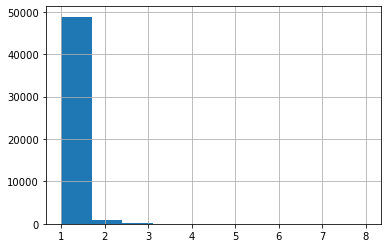

In [15]:
#The maximum avg_surge value appears extreme. 

#Inspect the distribution for the avg_surge column
df_users.avg_surge.hist();

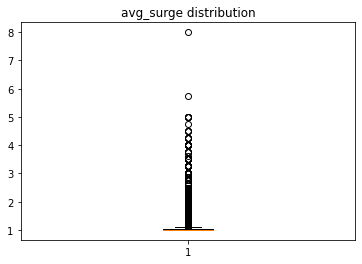

In [16]:
#boxplot of the avg_surge data
fig, ax = plt.subplots()
ax.boxplot(df_users.avg_surge);
ax.set_title('avg_surge distribution');

In [17]:
#users with an avg_surge value of 4 or more
mask = df_users.avg_surge >= 4
df_users[mask].sort_values(by='avg_surge', ascending=False)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
13861,Winterfell,1,2014-01-01,1.0,8.00,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0
30477,Winterfell,1,2014-01-01,5.0,5.75,2014-01-01,iPhone,100.0,False,100.0,1.98,5.0
21894,Winterfell,1,2014-01-10,4.9,5.00,2014-01-11,Android,100.0,False,100.0,2.46,4.0
47052,Winterfell,1,2014-01-09,4.9,5.00,2014-01-11,Android,100.0,False,100.0,2.96,5.0
19191,Winterfell,1,2014-01-10,5.0,5.00,2014-01-11,Android,100.0,False,100.0,3.37,5.0
49383,Winterfell,1,2014-01-10,4.9,5.00,2014-01-11,iPhone,100.0,False,100.0,2.40,5.0
2817,Winterfell,0,2014-01-02,5.0,5.00,2014-02-05,iPhone,100.0,False,100.0,3.18,5.0
1405,Winterfell,1,2014-01-08,5.0,4.75,2014-01-21,iPhone,100.0,False,100.0,6.46,5.0
15334,Winterfell,0,2014-01-13,4.9,4.50,2014-06-18,iPhone,100.0,False,100.0,1.40,5.0
21742,Winterfell,0,2014-01-19,4.9,4.50,2014-06-21,iPhone,100.0,False,0.0,1.42,5.0


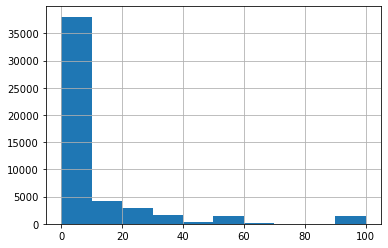

In [18]:
#The maximum surge_pct value appears extreme. 

#Inspect the distribution for the surge_pct column
df_users.surge_pct.hist();

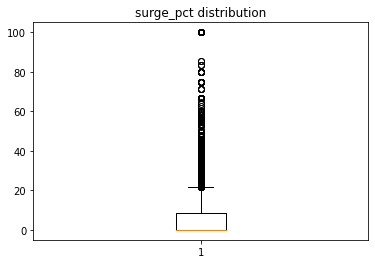

In [19]:
#boxplot of the surge_pct data
fig, ax = plt.subplots()
ax.boxplot(df_users.surge_pct);
ax.set_title('surge_pct distribution');

In [20]:
#users with a surge_pct value of 80 or more
mask = df_users.surge_pct >= 80
df_users[mask].sort_values(by='surge_pct', ascending=False)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
28,Winterfell,0,2014-01-19,4.9,1.50,2014-06-08,iPhone,100.0,False,0.0,5.97,5.0
34861,Astapor,1,2014-01-18,5.0,1.25,2014-01-19,iPhone,100.0,False,0.0,3.17,5.0
34023,Astapor,1,2014-01-18,5.0,2.50,2014-01-19,Android,100.0,False,0.0,2.51,4.0
33982,Winterfell,0,2014-01-02,4.9,2.25,2014-05-21,Android,100.0,False,100.0,1.94,5.0
33979,Astapor,1,2014-01-24,4.9,1.75,2014-01-25,Android,100.0,False,100.0,3.01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26454,Astapor,1,2014-01-19,4.5,2.25,2014-04-27,iPhone,80.0,False,0.0,5.53,4.0
39050,Astapor,3,2014-01-20,5.0,2.20,2014-06-05,iPhone,80.0,False,80.0,1.39,4.8
27241,Winterfell,4,2014-01-09,3.8,1.70,2014-02-09,iPhone,80.0,False,0.0,1.20,4.6
18601,Astapor,5,2014-01-25,4.3,1.45,2014-01-26,Android,80.0,False,0.0,1.82,5.0


## 2. Exploratory Data Analysis

## 2.1 User Retention

In [21]:
#note that a "current" date was not provided. Therefore, the latest last_trip_date was considered the "current" date.

#get the current date
current_date = df_users.last_trip_date.max()

#get the 'retention date' (the date 30 days ago)
retention_date = current_date - timedelta(days=30)

#create a "retained" column to indicate whether or not a user was retained
df_users['retained'] = df_users.last_trip_date >= retention_date

In [22]:
#what fraction of users were retained?
proportion_retained = sum(df_users.retained) / len(df_users.retained)
print('{}% of users were retained'.format(round(proportion_retained * 100,3)))

37.608% of users were retained


## 2.2 Potential Predictive Features

,retained,total_users,proportion_retained
city,,,
King's Landing,6363,10130,0.628134
Winterfell,8213,23336,0.351945
Astapor,4228,16534,0.255715


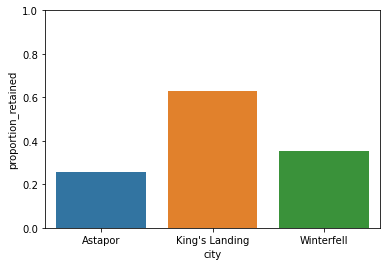

In [23]:
#look at proportion retained by city

#get the retained passengers and total passengers for each city
df_retained_by_city = df_users.groupby('city') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})

#add a proportion retained column
df_retained_by_city['proportion_retained'] = df_retained_by_city.retained / df_retained_by_city.total_users

#display the proportion data
display(df_retained_by_city.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by city
sns.barplot(data=df_retained_by_city, x=df_retained_by_city.index, y='proportion_retained');
plt.gca().set(ylim=(0,1));

,retained,total_users,proportion_retained
trips_in_first_30_days_bins,,,
"(6.0, 125.0]",2767,4000,0.691750
"(3.0, 6.0]",2896,5312,0.545181
"(2.0, 3.0]",1693,3788,0.446938
"(1.0, 2.0]",2743,7402,0.370576
"(-0.001, 1.0]",8705,29498,0.295105


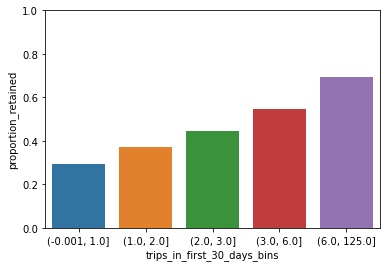

In [24]:
#look at trips in first 30 days

#bin the trips_in_first_30_days column
df_users['trips_in_first_30_days_bins'] = pd.qcut(df_users.trips_in_first_30_days, 10, duplicates='drop')

#get the retained passengers and total passengers for each trips_in_first_30_days bin
df_retained_by_first_trips = df_users.groupby('trips_in_first_30_days_bins') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})

#add a proportion retained column
df_retained_by_first_trips['proportion_retained'] = \
    df_retained_by_first_trips.retained / df_retained_by_first_trips.total_users


#display the proportion data
display(df_retained_by_first_trips.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by trips in first 30 days
sns.barplot(data=df_retained_by_first_trips, x=df_retained_by_first_trips.index, y='proportion_retained');
plt.gca().set(ylim=(0,1));

#drop the trips_in_first_30_days_bins column
df_users.drop(columns=['trips_in_first_30_days_bins'], inplace=True)

,retained,total_users,proportion_retained
avg_rating_of_driver_bins,,,
"(4.0, 5.0]",15973,41995,0.380355
"(3.0, 4.0]",2373,6301,0.376607
"(2.0, 3.0]",367,1229,0.298617
"(0.999, 2.0]",91,475,0.191579


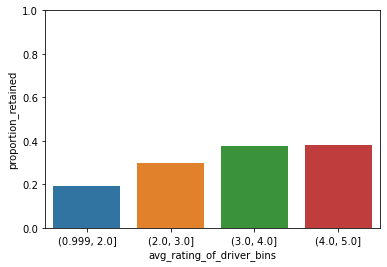

In [25]:
#look at average rating of driver

#bin the avg_rating_of_driver 
bins = [1,2,3,4,5]
df_users['avg_rating_of_driver_bins'] = pd.cut(df_users.avg_rating_of_driver, bins, include_lowest=True)

#get the retained passengers and total passengers for each avg_rating_of_driver bin
df_retained_by_driver_rating = df_users.groupby('avg_rating_of_driver_bins') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})


#add a proportion retained column
df_retained_by_driver_rating['proportion_retained'] = \
    df_retained_by_driver_rating.retained / df_retained_by_driver_rating.total_users


#display the proportion data
display(df_retained_by_driver_rating.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by driver rating
sns.barplot(data=df_retained_by_driver_rating, x=df_retained_by_driver_rating.index, y='proportion_retained');
plt.gca().set(ylim=(0,1));

#drop the avg_rating_of_driver_bins column
df_users.drop(columns=['avg_rating_of_driver_bins'], inplace=True)

,retained,total_users,proportion_retained
avg_surge_bins,,,
"(1.04, 1.08]",1964,2888,0.680055
"(1.08, 1.16]",2326,3480,0.668391
"(1.16, 1.29]",1637,3169,0.516567
"(0.999, 1.04]",11875,37140,0.319736
"(1.29, 8.0]",1002,3323,0.301535


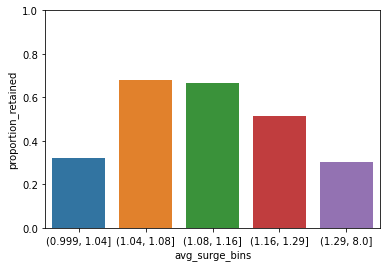

In [26]:
#look at average surge

#bin the avg_surge column
df_users['avg_surge_bins'] = pd.qcut(df_users.avg_surge, 15, duplicates='drop')

#get the retained passengers and total passengers for each avg_surge bin
df_retained_by_avg_surge = df_users.groupby('avg_surge_bins') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})

#add a proportion retained column
df_retained_by_avg_surge['proportion_retained'] = \
    df_retained_by_avg_surge.retained / df_retained_by_avg_surge.total_users

#display the proportion data
display(df_retained_by_avg_surge.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by driver rating
sns.barplot(data=df_retained_by_avg_surge, x=df_retained_by_avg_surge.index, y='proportion_retained');
plt.gca().set(ylim=(0,1));

#drop the avg_surge_bins column
df_users.drop(columns=['avg_surge_bins'], inplace=True)

,retained,total_users,proportion_retained
phone,,,
iPhone,15525,34582,0.448933
Unknown,133,396,0.335859
Android,3146,15022,0.209426


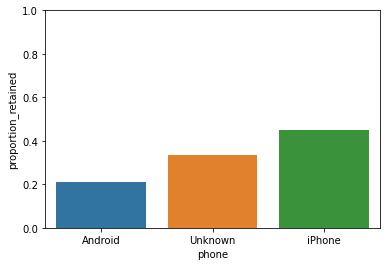

In [27]:
#look at proportion retained by phone

#get the retained passengers and total passengers for each phone type
df_retained_by_city = df_users.groupby('phone') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})

#add a proportion retained column
df_retained_by_city['proportion_retained'] = df_retained_by_city.retained / df_retained_by_city.total_users

#display the proportion data
display(df_retained_by_city.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by phone
sns.barplot(data=df_retained_by_city, x=df_retained_by_city.index, y='proportion_retained');
plt.gca().set(ylim=(0,1));

,retained,total_users,proportion_retained
surge_pct_bins,,,
"(7.1, 13.7]",2446,3185,0.767975
"(13.7, 22.2]",2199,3418,0.643359
"(22.2, 40.0]",1657,3337,0.496554
"(-0.001, 7.1]",11747,36817,0.319065
"(40.0, 100.0]",755,3243,0.232809


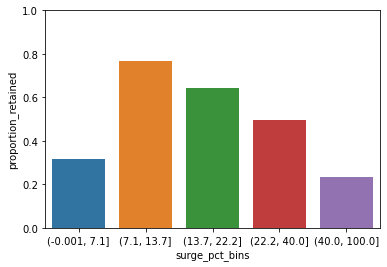

In [28]:
#look at proportion retained by surge_pct

#bin the surge_pct column
df_users['surge_pct_bins'] = pd.qcut(df_users.surge_pct, 15, duplicates='drop')

#get the retained passengers and total passengers for each surge_pct bin
df_retained_by_surge_pct = df_users.groupby('surge_pct_bins') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})

#add a proportion retained column
df_retained_by_surge_pct['proportion_retained'] = \
    df_retained_by_surge_pct.retained / df_retained_by_surge_pct.total_users

#display the proportion data
display(df_retained_by_surge_pct.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by driver rating
sns.barplot(data=df_retained_by_surge_pct, x=df_retained_by_surge_pct.index, y='proportion_retained');
plt.gca().set(ylim=(0,1));

#drop the surge_pct_bins column
df_users.drop(columns=['surge_pct_bins'], inplace=True)

,retained,total_users,proportion_retained
ultimate_black_user,,,
True,9497,18854,0.503713
False,9307,31146,0.298818


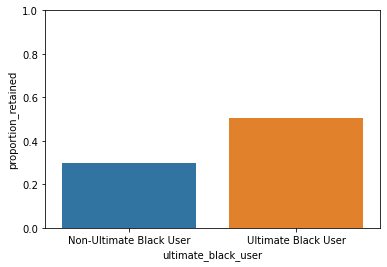

In [29]:
#look at proportion retained by ultimate black users

#get the retained passengers and total passengers for ultimate black and non-ultimate black users
df_retained_by_ultimate_black = df_users.groupby('ultimate_black_user') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})

#add a proportion retained column
df_retained_by_ultimate_black['proportion_retained'] = \
    df_retained_by_ultimate_black.retained / df_retained_by_ultimate_black.total_users

#display the proportion data
display(df_retained_by_ultimate_black.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by ultimate black vs. non-ultimate black
sns.barplot(data=df_retained_by_ultimate_black, \
            x=df_retained_by_ultimate_black.index.astype(int), y='proportion_retained');
plt.xticks((0, 1), ('Non-Ultimate Black User', 'Ultimate Black User'))
plt.gca().set(ylim=(0,1));

,retained,total_users,proportion_retained
weekday_pct_bins,,,
"(50.0, 60.0]",1929,2813,0.685745
"(80.0, 90.0]",1409,2090,0.674163
"(70.0, 80.0]",2321,3762,0.616959
"(60.0, 70.0]",2543,4221,0.602464
"(20.0, 30.0]",719,1299,0.553503
"(10.0, 20.0]",425,823,0.516403
"(30.0, 40.0]",1444,2935,0.491993
"(40.0, 50.0]",2466,5469,0.450905
"(90.0, 100.0]",3907,17321,0.225564


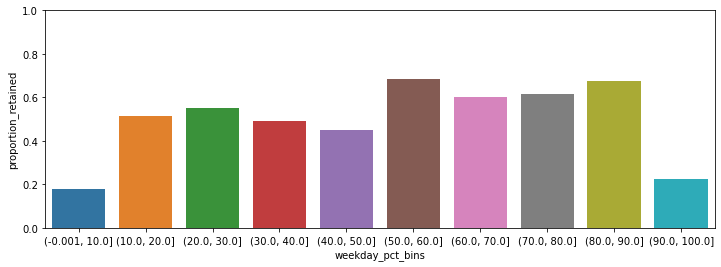

In [30]:
#look at proportion retained by weekday percentage

#bin the weekday_pct 
bins = np.linspace(0,100,11)
df_users['weekday_pct_bins'] = pd.cut(df_users.weekday_pct, bins, include_lowest=True)

#get the retained passengers and total passengers for each weekday_pct bin
df_retained_by_weekday_pct = df_users.groupby('weekday_pct_bins') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})


#add a proportion retained column
df_retained_by_weekday_pct['proportion_retained'] = \
    df_retained_by_weekday_pct.retained / df_retained_by_weekday_pct.total_users

#display the proportion data
display(df_retained_by_weekday_pct.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by weekday percentage
plt.figure(figsize=(12,4))
sns.barplot(data=df_retained_by_weekday_pct, x=df_retained_by_weekday_pct.index, y='proportion_retained');
plt.gca().set(ylim=(0,1));

#drop the weekday_pct_bins column
df_users.drop(columns=['weekday_pct_bins'], inplace=True)

,retained,total_users,proportion_retained
avg_dist_bins,,,
"(3.21, 3.88]",2358,4989,0.472640
"(2.68, 3.21]",2312,4947,0.467354
"(3.88, 4.75]",2311,5019,0.460450
"(2.17, 2.68]",2244,5011,0.447815
"(4.75, 6.01]",2049,4982,0.411281
"(1.59, 2.17]",1871,4985,0.375326
"(6.01, 8.18]",1837,5004,0.367106
"(8.18, 13.11]",1585,4995,0.317317
"(-0.001, 1.59]",1136,5076,0.223798


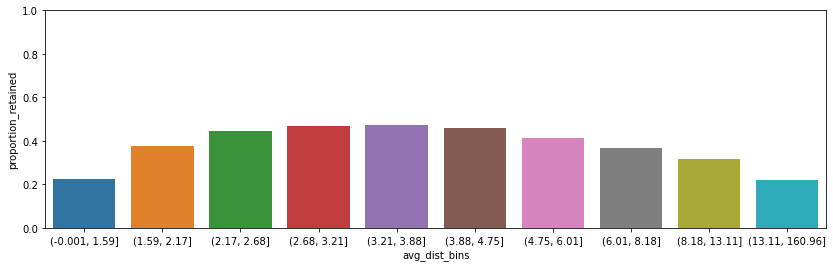

In [31]:
#look at proportion retained by average distance

#bin the avg_dist 
df_users['avg_dist_bins'] = pd.qcut(df_users.avg_dist, 10, duplicates='drop')

#get the retained passengers and total passengers for each avg_dist bin
df_retained_by_avg_dist = df_users.groupby('avg_dist_bins') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})


#add a proportion retained column
df_retained_by_avg_dist['proportion_retained'] = \
    df_retained_by_avg_dist.retained / df_retained_by_avg_dist.total_users

#display the proportion data
display(df_retained_by_avg_dist.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by average distance
plt.figure(figsize=(14,4))
sns.barplot(data=df_retained_by_avg_dist, x=df_retained_by_avg_dist.index, y='proportion_retained');
plt.gca().set(ylim=(0,1));

#drop the avg_dist_bins column
df_users.drop(columns=['avg_dist_bins'], inplace=True)

,retained,total_users,proportion_retained
avg_rating_by_driver_bins,,,
"(4.0, 5.0]",18071,46517,0.388482
"(3.0, 4.0]",607,2533,0.239637
"(2.0, 3.0]",87,639,0.136150
"(0.999, 2.0]",39,311,0.125402


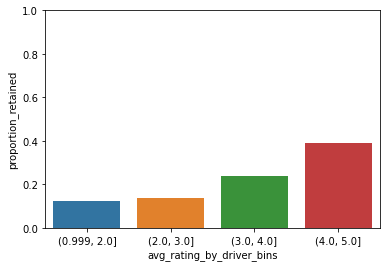

In [32]:
#look at average rating by driver

#bin the avg_rating_by_driver 
bins = [1,2,3,4,5]
df_users['avg_rating_by_driver_bins'] = pd.cut(df_users.avg_rating_by_driver, bins, include_lowest=True)

#get the retained passengers and total passengers for each avg_rating_by_driver bin
df_retained_by_user_rating = df_users.groupby('avg_rating_by_driver_bins') \
    .agg({'retained':'sum','signup_date':'count'}) \
    .rename(columns={'signup_date':'total_users'})


#add a proportion retained column
df_retained_by_user_rating['proportion_retained'] = \
    df_retained_by_user_rating.retained / df_retained_by_user_rating.total_users


#display the proportion data
display(df_retained_by_user_rating.sort_values(by='proportion_retained', ascending=False))

#plot the proportion retained by driver rating
sns.barplot(data=df_retained_by_user_rating, x=df_retained_by_user_rating.index, y='proportion_retained');
plt.gca().set(ylim=(0,1));

#drop the avg_rating_by_driver_bins column
df_users.drop(columns=['avg_rating_by_driver_bins'], inplace=True)

## 2.3 Correlations

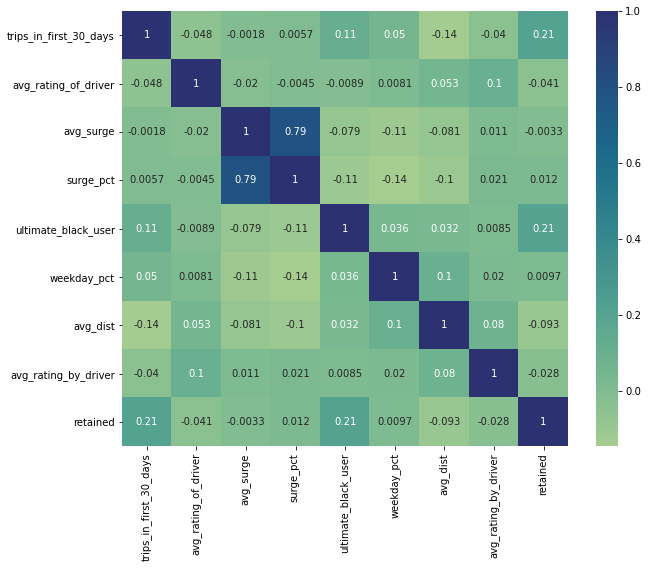

In [33]:
plt.figure(figsize=(10,8))
sns.heatmap(df_users.corr(), cmap='crest', annot=True);

## 2.4 Drop Unneeded Columns

In [34]:
#drop the last_trip_date and signup_date columns
df_users.drop(columns= ['last_trip_date','signup_date'], inplace=True)

## 3. Feature Engineering

In [35]:
#combine surge_pct and avg_surge into a single feature (surge_product) and drop the original features

#create the surge_product feature
df_users['surge_product'] = df_users.surge_pct * df_users.avg_surge

#drop surge_pct and avg_surge features
df_users.drop(columns=['surge_pct','avg_surge'], inplace=True)

In [36]:
#create a total distance traveled in the first 30 days feature (total_distance_first_30_days)
df_users['total_distance_first_30_days'] = df_users.trips_in_first_30_days * df_users.avg_dist

## 4. Preprocessing

In [37]:
#set a value from random state to ensure repeatability
random_state=42

In [38]:
#convert boolean columns (ultimate_black_user, retained) to integer columns
df_users['ultimate_black_user'] = df_users.ultimate_black_user.astype(int)
df_users['retained'] = df_users.retained.astype(int)

In [39]:
#separate X (feature matrix) and y (target vector)
X = df_users.drop(columns=['retained'])
y = df_users.retained

In [40]:
#train/test split
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, train_size=0.7, stratify=y, random_state=random_state)

In [41]:
#encode categorical columns using One Hot Encoding

#get the categorical columns from the training data
categorical_columns = ['city', 'phone']
df_categorical = X_train[categorical_columns]

#initialize the One Hot encoder
encoder = preprocessing.OneHotEncoder(sparse=False)

#fit the encoder to the training data, encode the training data, add the encoded columns to the dataframe
encoded_cols = encoder.fit_transform(df_categorical)
df_encoded = pd.DataFrame(encoded_cols, 
                          columns=encoder.get_feature_names(categorical_columns),
                         index=X_train.index)
X_train = pd.concat([X_train,df_encoded], axis=1)

#drop the original categorical columns
X_train.drop(columns=categorical_columns, inplace=True)


#get the categorical columns from the test data
df_categorical = X_test[categorical_columns]

#encode the test data using the encoder that was fitted to the training data
encoded_cols = encoder.transform(df_categorical)
df_encoded = pd.DataFrame(encoded_cols, 
                          columns=encoder.get_feature_names(categorical_columns),
                         index=X_test.index)
X_test = pd.concat([X_test,df_encoded], axis=1)

#drop the original categorical columns
X_test.drop(columns=categorical_columns, inplace=True)

In [42]:
#scale numerical columns using stanard scaling

#get the numerical columns for the training data
numerical_columns = list(set(df_users.columns) - set(['city','phone','retained']))
df_numerical = X_train[numerical_columns]

#initialize the standard scaler
scaler = preprocessing.StandardScaler()

#fit the scaler to the training data, scale the training data, add the scaled columns to the dataframe
scaled_cols = scaler.fit_transform(df_numerical)
df_scaled = pd.DataFrame(scaled_cols, columns=numerical_columns, index=X_train.index)
X_train.drop(columns=numerical_columns, inplace=True)
X_train = pd.concat([X_train,df_scaled], axis=1)

#get the numerical columns for the test data
df_numerical = X_test[numerical_columns]

#encode the test data using the scaler that was fitted to the training data
scaled_cols = scaler.transform(df_numerical)
df_scaled = pd.DataFrame(scaled_cols, columns=numerical_columns, index=X_test.index)
X_test.drop(columns=numerical_columns, inplace=True)
X_test = pd.concat([X_test,df_scaled], axis=1)

## 5.  Modeling

In [43]:
#method to train, predict, and score (ROC-AUC score) each model
def train_predict_score(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    
    train_accuracy = metrics.accuracy_score(y_train,model.predict(X_train))
    train_auc = metrics.roc_auc_score(y_train,model.predict_proba(X_train)[:,1])
    
    test_accuracy = metrics.accuracy_score(y_test,model.predict(X_test))
    test_auc = metrics.roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
      
    return dict({
        'Train Accuracy':train_accuracy,
        'Train AUC': train_auc,
        'Test Accuracy':test_accuracy,
        'Test AUC':test_auc})

In [44]:
#DataFrame to hold scores
model_scores = pd.DataFrame(columns=['Model','Train Accuracy','Train AUC','Test Accuracy','Test AUC'])

In [45]:
#baseline model
dummy_model = dummy.DummyClassifier(random_state = random_state, strategy='uniform')

dict_score = train_predict_score(dummy_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Dummy'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [46]:
#initial logistic regression model
lr_model = linear_model.LogisticRegression(random_state=random_state)

dict_score = train_predict_score(lr_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Logistic Regression'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [47]:
#initial gradient boosting model
gb_model = ensemble.GradientBoostingClassifier(random_state=random_state)

dict_score = train_predict_score(gb_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Gradient Boosting'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [48]:
#initial random forest model
rf_model = ensemble.RandomForestClassifier(random_state=random_state)

dict_score = train_predict_score(rf_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Random Forest'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [49]:
#inspect the initial model scores
display(model_scores.sort_values(by='Test AUC', ascending=False))

,Model,Train Accuracy,Train AUC,Test Accuracy,Test AUC
2,Gradient Boosting,0.788686,0.856930,0.787867,0.851371
3,Random Forest,0.996800,0.999932,0.756000,0.823874
1,Logistic Regression,0.719514,0.764801,0.714267,0.753316
0,Dummy,0.503429,0.500000,0.495733,0.500000


In [50]:
#The Gradient Boosting model was the best performer - see if the model can be improved using hyperparameter tuning

#define the hyperparameter search grid
param_grid = {
    'learning_rate':[0.001,0.01,0.1],
    'max_depth':[3,6,9]
}

#apply grid search 
tuned_model = model_selection.GridSearchCV(gb_model, 
                                           param_grid, 
                                           scoring='roc_auc', 
                                           n_jobs=-1, 
                                           cv=5).fit(X_train,y_train)

#best parameters
tuned_model.best_params_

{'learning_rate': 0.1, 'max_depth': 6}

In [51]:
#fit/test/score the model with the optimized parameters

tuned_model = tuned_model.best_estimator_

dict_score = train_predict_score(tuned_model, X_train, y_train, X_test, y_test)
dict_score['Model'] = 'Gradient Boosting (Tuned)'

model_scores = model_scores.append(dict_score, ignore_index=True)

In [52]:
#inspect all model scores
display(model_scores.sort_values(by='Test AUC', ascending=False))

,Model,Train Accuracy,Train AUC,Test Accuracy,Test AUC
4,Gradient Boosting (Tuned),0.817457,0.892967,0.790667,0.857665
2,Gradient Boosting,0.788686,0.856930,0.787867,0.851371
3,Random Forest,0.996800,0.999932,0.756000,0.823874
1,Logistic Regression,0.719514,0.764801,0.714267,0.753316
0,Dummy,0.503429,0.500000,0.495733,0.500000


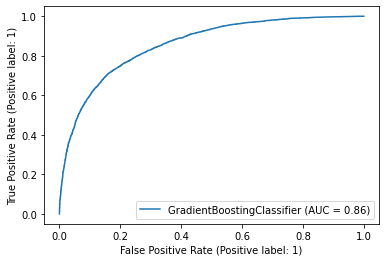

In [53]:
#plot the roc curve for the best model
metrics.plot_roc_curve(tuned_model, X_test, y_test);

## Feature Importance

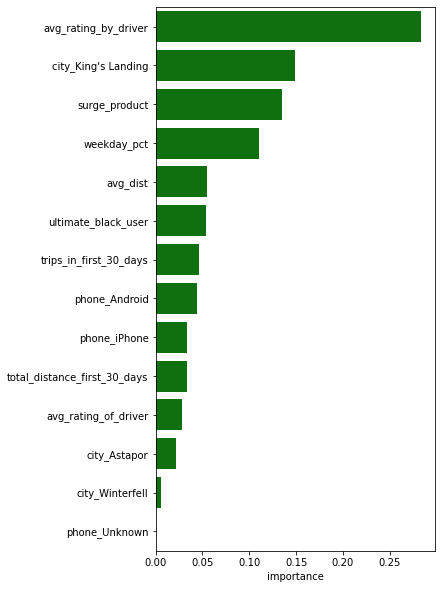

In [54]:
#examine feature importances

df_feature_importances = \
    pd.DataFrame(tuned_model.feature_importances_, index=X_train.columns, columns=['importance']) \
        .sort_values(by='importance', ascending=False)


plt.figure(figsize=(5,10))
sns.barplot(data=df_feature_importances, y=df_feature_importances.index, x='importance', color='green', orient='h');